# Movielens 영화 SBR

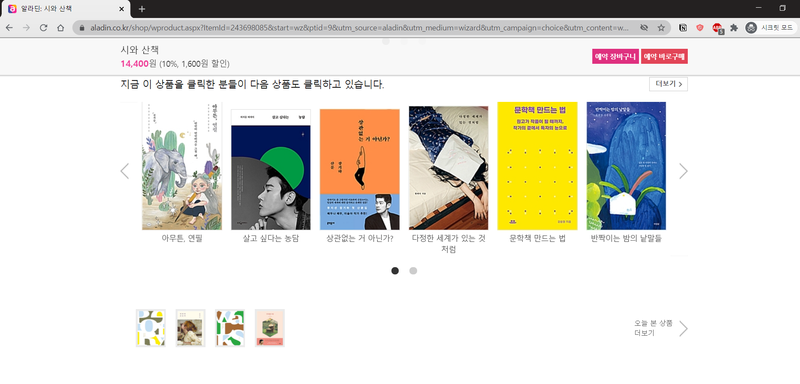

온라인 서점 '알라딘에서 책을 구경을 했다. 하지만 정보를 남길 생각이 없으므로 시크릿 모드를 이용해 로그인하지 않고 돌아다녔다. 문제는 내가 클릭한 책들이 오늘 본 상품에 기록되어 있었고, 책 상세페이지 영역에 다른 책들을 추천하고 있었다.

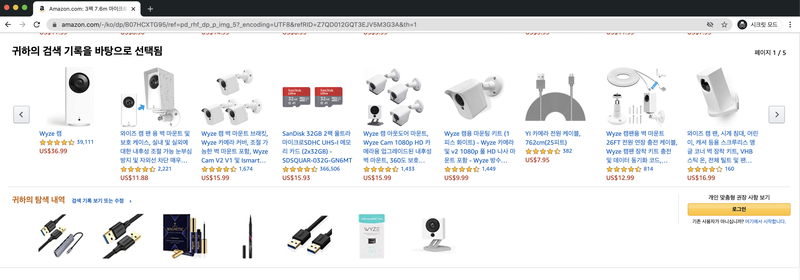

아마존 역시 마찬가지였다. 시크릿 모드를 켜놓고 캠을 사기 위해 이것저것 서핑하고 보니 어느새 탐색 내역이 기록되어 있었고, 이를 바탕으로 한 추천을 해주고 있었다.

## Session-Based Recommendation

오늘은 전자상거래 플랫폼에서 많이 사용하고 있는 Session-Based Recommendation에 대해 알아보겠다.

고객에게 그 고객과 유사한 다른 고객이 좋아하는 상품을 추천해 주는 전략은 언제나 유효할까? 이런 추천 전략에의 기본 전제에는 한 가지 맹점이 있는 것 같다. 고객의 선호가 고정된 것이라고 보는 것이다. 그러나 고객의 마음은 늘 변덕스럽기 마련이다. 그래서 전자상거래 플랫폼에서는 '바로 지금 시점에 이 고객이 좋아할 만한 상품'을 추천해 주고 싶어 한다. 그렇다면 이 고객이 바로 지금 좋아할만 한 것을 알아낼 단서는 어디에 있을까?

Session-Based Recommendation은 말 그대로 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천을 말한다.  
Session이란 앞에서 살펴보았듯이 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장된다.  
유저의 행동 데이터들은 유저 측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고받는다.  
이번 자료에서는 세션을 브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터와 같은 의미로 사용하겠다.  
자세한 내용은 [참고 자료 1][1], [참고자료 2][2]를 확인한다.

[1]:https://www.youtube.com/watch?v=OpoVuwxGRDI&feature=emb_title
[2]:https://chrisjune-13837.medium.com/web-%EC%BF%A0%ED%82%A4-%EC%84%B8%EC%85%98%EC%9D%B4%EB%9E%80-aa6bcb327582

아래와 같은 데이터가 예시이다.

9194111 Session의 유저가 8분여에 걸쳐 4개의 아이템(214853420 214850942 214829878 214853420)을 본 상황이다.  
유저가 214853420 아이템을 보았을 때 214850942를 추천하고 이어서 214850942를 보았을 때 214829878을 추천하고 싶다.

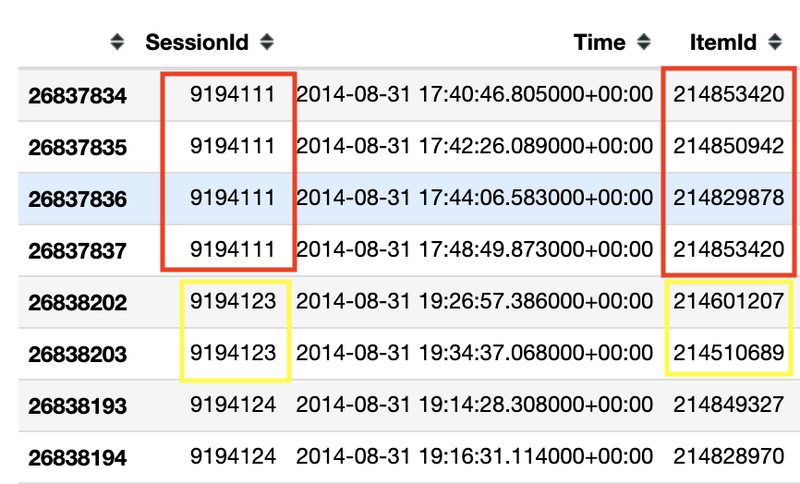

추천 시스템을 주로 다루는 학회 RecSys에서는 매년 추천을 주제로 대회를 개최한다.  
2015년도에는 YOOCHOOSE라는 추천 엔진 솔루션 회사에서 E-Commerce 데이터를 공개했다.

### 프로젝트 폴더 생성
### 데이터 폴더에서 프로젝트 폴더로의 링크 연결

In [1]:
# mkdir -p ~/aiffel/yoochoose/data
# ln -s ~/data/* ~/aiffel/yoochoose/data

Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠다.

우선 주요 라이브러리 버전을 확인해 보자.

In [2]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


## 라이브러리 import하기

In [3]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 1) 데이터 확인  
# ls -l ~/data

# 2) 프로젝트 폴더 생성  
# mkdir -p ~/aiffel/yoochoose

# 3) 프로젝트 폴더로 데이터 폴더 링크 연결  
# ln -s ~/data/* ~/aiffel/yoochoose/data

In [5]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


● 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점이다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있다. 그래서 이번에는 UserID가 SessionID 역할을 해야 한다.

● Rating 정보가 포함되어 있다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 한다.

● Time 항목에는 UTC time가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠다.

## Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행한다.  
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의한다.

### 기본 분석

In [6]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 이다.

유저의 수가 6040명이고, 아이템 숫자는 3706개이다. 잘 생각해보면 한 유저가 여러 개의 아이디를 만들었을 수도 있다는 생각이 든다.

※ 이전 실습의 세션의 숫자가 약 900만 개, 아이템 숫자는 약 5만 개였다.  
하지만 이 수치가 유저의 수가 900만 명이라는 것은 아니다. 같은 유저가 여러 개의 세션을 만들 수도 있기 때문이다.

### Session Length

In [7]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

중앙값은 96이고, 평균값은 165이다.

In [9]:
user_length.min(), user_length.max()

(20, 2314)

최솟값은 20이고, 최댓값은 2314이다.

In [10]:
user_length.quantile(0.999)

1343.181000000005

99.9%는 1343이하다.

In [11]:
long_session = user_length[user_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


짧은 간격으로 지속적인 것을 확인할 수 있다.

※ 유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단해야 한다.  
ex) 음악 데이터의 경우 어떤 사람은 하루 종일 랜덤 재생을 할 수도 있다. 이 유저의 데이터를 그대로 사용하는게 좋을까?  
ex) 어떤 상품의 경우 1분 내에 20명이 10점을 주고 나갈 수도 있다. 이 상품을 팔기 위해 조작하고 있는 건 아닐까?

너무 긴 세션을 제거할 수도 있고 포함시킬 수도 있다. 어떻게 하면 좋을지 판단해 봐야 한다.

세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠다. 아래는 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것이다.

In [12]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

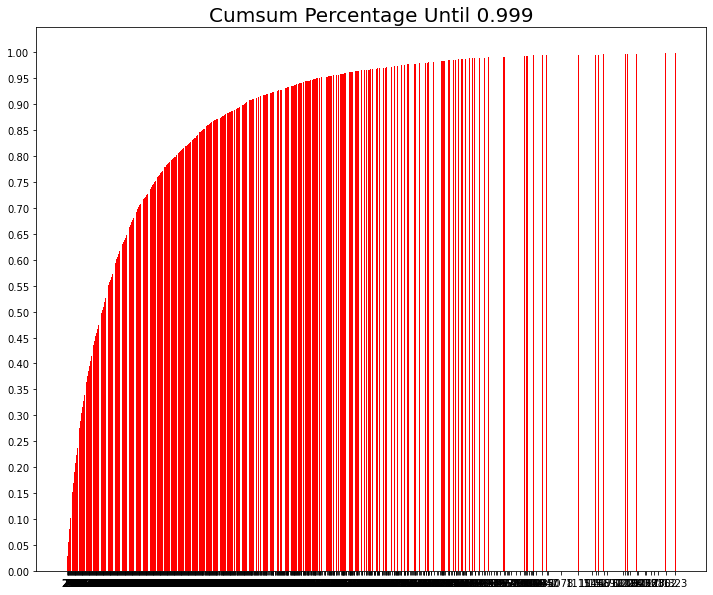

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

● 어떤 유저가 아이폰을 구매하려고 한다. 2020년 5월에는 아이폰 SE2를 구매하려는 사람이 많을 것이다.

● 그러나 그로부터 몇 달 후면 아이폰 12의 구매량이 엄청나게 증가하게 될 것이다.

● 영화나 드라마 역시 마찬가지입니다. 유저들의 소비 패턴을 금방금방 변한다.

● 이런 이유 때문에 추천 시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요하다. 이번에는 데이터가 발생한 시간에 대해 알아보자.

그렇다면 우리가 다루려는 데이터의 시간 관련 정보를 확인해 보자.

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


3년치 데이터가 있다.

In [15]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않는다.  
날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용한다.

In [16]:
# month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
# data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

데이터가 작은 편이므로 데이터 전부를 사용한다.

### Data Cleansing

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_watch) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_watch)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_watch):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_watch].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=2, least_watch=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


길이가 1인 세션도 있다. 다음이 예상이 안되므로 제거한다. 너무 적은 수치도 제거한다.

### Train / Valid / Test split

모델 평가를 위해 Valid Set과 Test Set을 만든다.

In [19]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max().sort_values()
    session_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    session_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = session_in_train
    after_date = session_in_test
    return before_date, after_date

In [20]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [21]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [22]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 996233
	 Sessions: 6040
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-12-30 16:54:04

* valid Set Stats Info
	 Events: 1827
	 Sessions: 135
	 Items: 1155
	 First Time : 2002-12-30 18:21:02
	 Last Time : 2003-01-29 17:00:13

* test Set Stats Info
	 Events: 1551
	 Sessions: 103
	 Items: 1008
	 First Time : 2003-01-29 19:36:56
	 Last Time : 2003-02-28 17:49:50



3년치 데이터 중 대부분을 train 데이터에 할당하고, valid 데이터와 test 데이터에 각각 한 달 씩 할당한다.

In [23]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

이제 데이터 준비를 마쳤다. 데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어가겠다.

In [24]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 논문소개(GRU4REC)

이번 자료에서 사용할 모델은 2016년 ICLR에 공개된 [SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS][1]이다.
Session Data에서는 처음으로 RNN 계열 모델을 적용하여 발표했다.

모델 구조는 아래 그림처럼 간단하다.

여러 RNN 계열의 모델(e.g. LSTM)이 있겠지만 실험해 본 결과 GRU의 성능이 제일 좋았다고 힌다.  
또한 Embedding Layer를 사용하지 않았을 때가 사용했을 때보다 성능이 좋았다고 한다.  
이번 자료에서도 Embedding Layer를 사용하지 않고 One-hot Encoding만 사용하겠다.

[1]:https://arxiv.org/pdf/1511.06939v4.pdf

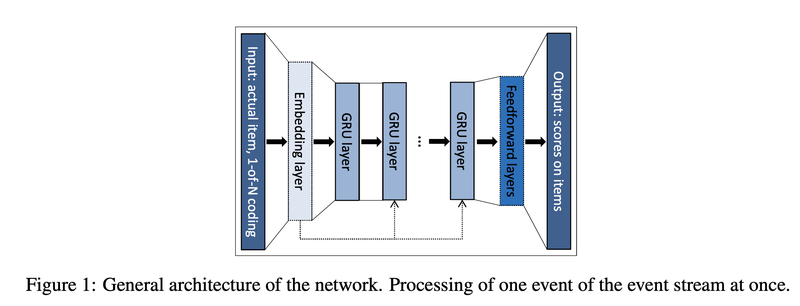

대신 추천 데이터의 특징 몇 가지를 살려 모델링을 했다.

Session-Parallel Mini-Batches :  
위에서 보았듯이 Session의 길이는 매우 짧은 것들이 대부분이다. 그러나 매우 긴 것들도 있다.  
이 세션들을 데이터 샘플 하나로 보고 mini-batch를 구성하여 input으로 넣는다면 길이가 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야 한다.

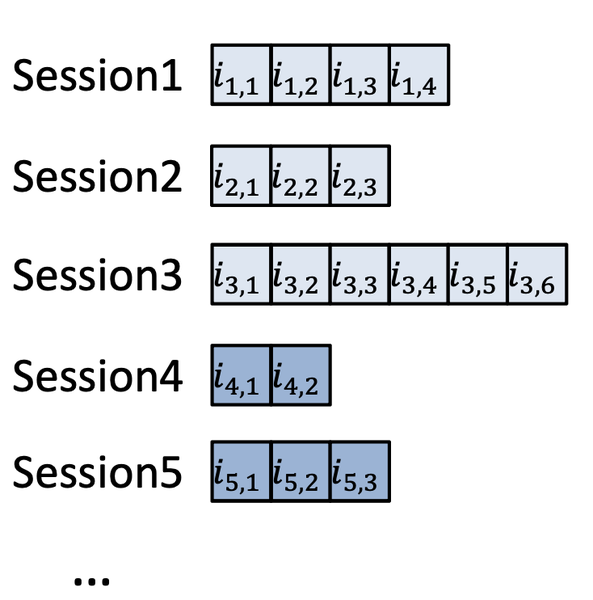

위 그림에서 Session 1, 2, 3을 하나의 mini-batch로 만든다면, 이 미니 배치의 연산은 Session 3의 연산이 끝나야 끝나는 식이다.  
논문의 저자는 대신 Session-Parallel Mini-Batches를 제안한다. 이름처럼 Session이 끝날 때까지 기다리지 않고 병렬적으로 계산하자는 뜻이다.  
아래 그림에서 session2가 끝나면 session4가 시작하는 방식이다.  
이렇게 구성했을 때 Mini-Batch의 shape은 (3, 1, 1)이 되고 RNN cell의 state가 1개로만 이루어진다.  
또한 Tensorflow 기준으로 RNN을 만들 때 stateful=True 옵션을 사용하고 2처럼 세션이 끝나면 state를 0으로 만들어 준다.


● [RNN API 보기][1]

[1]:https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN

뒷부분에서 이 부분에 대한 코딩을 어떻게 했는지 보자.

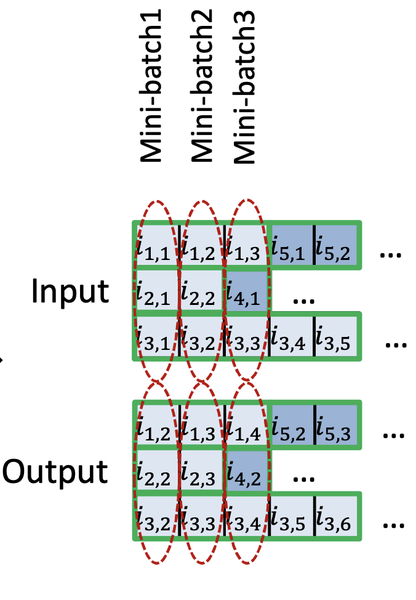

SAMPLING ON THE OUTPUT : Negative Sampling와 같은 개념이다. Item의 수가 많기 때문에 Loss를 계산할 때 모든 아이템을 비교하지 않고 인기도를 고려하여 Sampling한다. 이번 자료에서는 구현하지 않았다.

Ranking Loss Session-Based Recommendation Task를 여러 아이템 중 다음 아이템이 무엇인지 Classification하는 Task로 생각할 수도 있다.  
그러나 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task로도 생각할 수 있다.  
추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자 역시 이런 Loss를 사용했다.  
그러나 이번 자료에서는 Classification Task로 보고 Cross-Entropy Loss를 사용하겠다.

자세한 내용은 [논문][1]을 참고한다.

[1]:https://arxiv.org/pdf/1511.06939v4.pdf

## Step 2. 미니 배치의 구성

이전 스텝에서 개념을 정리해 본 Session-Parallel Mini-Batch를 구현해 보자.

Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성한다.  
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있다.

### SessionDataset

In [25]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

In [26]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [27]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 995769, 995892, 996233], dtype=int32)

In [28]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6037, 6038, 6039])

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보았다.  
click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있다.  
session_idx 변수는 각 세션을 인덱싱한 np.array이다.

### SessionDataLoader

파이썬 문법 중 iterator, generator에 대한 지식이 필요하다면 이 [자료][1]를 먼저 보면 된다.

[1]:https://dojang.io/mod/page/view.php?id=2405

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다.  
__iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield한다.  
mask는 후에 RNN Cell State를 초기화하는데 사용할 것이다.

In [29]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [30]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [31]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만든다.  
input, output, mask의 감을 잡아 보자.

In [32]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있다.

### Evaluation Metric

모델 성능 평가를 위한 지표를 보겠다.  
모델 성능에 대한 지표로 precision이나 recall이 있다.  
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋다.  
이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용한다.  
추천에서는 몇 번째로 맞추느냐도 중요하다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것이다.  
따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용한다.  
이번 자료에서는 MRR과 Recall@k를 사용하겠다. MRR은 정답 아이템이 나온 순번의 역수 값이다.  
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것이다.

In [33]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

스텝 3에서 소개한 모델 구조를 구현하겠다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠다.

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [35]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠다.

In [36]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [37]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      520200    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

### Model Training

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 한다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 한다.

지금까지 준비한 데이터셋과 모델을 통해 학습을 진행해야 한다.

모델 학습에 걸리는 시간은 epoch당 30분이 넘어간다.

배치 사이즈나 epoch 등의 설정은 위의 args에서 관리하므로 참고한다.

In [38]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [39]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

# 학습된 모델을 불러옵니다.
# model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  37%|███▋      | 19/52 [00:03<00:05,  5.74it/s]


	 - Recall@20 epoch 1: 0.126645
	 - MRR@20    epoch 1: 0.040436



Evaluation:  37%|███▋      | 19/52 [00:03<00:05,  6.20it/s]


	 - Recall@20 epoch 2: 0.143092
	 - MRR@20    epoch 2: 0.048891



Evaluation:  37%|███▋      | 19/52 [00:03<00:05,  6.26it/s]

	 - Recall@20 epoch 3: 0.148026
	 - MRR@20    epoch 3: 0.053026



## Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 본다.

### Inference

지금까지 작성한 모델이 테스트셋에 대해서 어느 정도 성능을 내는지 검증해 보자.

In [40]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  18%|█▊        | 8/45 [00:01<00:05,  6.18it/s]

	 - Recall@20: 0.121094
	 - MRR@20: 0.038296



In [41]:
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model = create_model(args)
train_model(model, args)

test_model(model, args, test)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(16, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      520200    
_________________________________________________________________
dropout_1 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (16, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  49%|████▊     | 51/105 [00:05<00:05, 10.00it/s]


	 - Recall@20 epoch 1: 0.136029
	 - MRR@20    epoch 1: 0.036462



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.69it/s]


	 - Recall@20 epoch 2: 0.140931
	 - MRR@20    epoch 2: 0.045499



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.77it/s]


	 - Recall@20 epoch 3: 0.143382
	 - MRR@20    epoch 3: 0.048740



Evaluation:  34%|███▍      | 31/90 [00:02<00:05, 10.89it/s]

	 - Recall@20: 0.147177
	 - MRR@20: 0.053331



In [42]:
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

test_model(model, args, test)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(16, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      520200    
_________________________________________________________________
dropout_2 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (16, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  49%|████▊     | 51/105 [00:05<00:05,  9.58it/s]


	 - Recall@20 epoch 1: 0.129902
	 - MRR@20    epoch 1: 0.036014



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.49it/s]


	 - Recall@20 epoch 2: 0.144608
	 - MRR@20    epoch 2: 0.039806



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.71it/s]


	 - Recall@20 epoch 3: 0.143382
	 - MRR@20    epoch 3: 0.047076



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.39it/s]


	 - Recall@20 epoch 4: 0.138480
	 - MRR@20    epoch 4: 0.046447



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.60it/s]


	 - Recall@20 epoch 5: 0.134804
	 - MRR@20    epoch 5: 0.049002



Evaluation:  34%|███▍      | 31/90 [00:02<00:05, 10.71it/s]

	 - Recall@20: 0.135081
	 - MRR@20: 0.047000



In [43]:
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)
train_model(model, args)

test_model(model, args, test)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(16, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      520200    
_________________________________________________________________
dropout_3 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (16, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  49%|████▊     | 51/105 [00:05<00:05, 10.13it/s]


	 - Recall@20 epoch 1: 0.144608
	 - MRR@20    epoch 1: 0.041980



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.80it/s]


	 - Recall@20 epoch 2: 0.147059
	 - MRR@20    epoch 2: 0.049591



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.61it/s]


	 - Recall@20 epoch 3: 0.159314
	 - MRR@20    epoch 3: 0.052176



Evaluation:  49%|████▊     | 51/105 [00:05<00:05, 10.02it/s]


	 - Recall@20 epoch 4: 0.162990
	 - MRR@20    epoch 4: 0.048445



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.46it/s]


	 - Recall@20 epoch 5: 0.166667
	 - MRR@20    epoch 5: 0.045952



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.45it/s]


	 - Recall@20 epoch 6: 0.150735
	 - MRR@20    epoch 6: 0.048311



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.47it/s]


	 - Recall@20 epoch 7: 0.158088
	 - MRR@20    epoch 7: 0.046713



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.68it/s]


	 - Recall@20 epoch 8: 0.153186
	 - MRR@20    epoch 8: 0.049376



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.45it/s]


	 - Recall@20 epoch 9: 0.153186
	 - MRR@20    epoch 9: 0.049777



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.69it/s]


	 - Recall@20 epoch 10: 0.155637
	 - MRR@20    epoch 10: 0.047162



Evaluation:  34%|███▍      | 31/90 [00:02<00:05, 10.77it/s]

	 - Recall@20: 0.137097
	 - MRR@20: 0.053589



## 모델 평가

하이퍼 파라미터 중 어떤 것을 변경해야 할 지 생각을 해 보았는데 그동안의 경험을 통해 몇 가지만 변경하기로 하였다. batch_size와 epochs만 변경했다.  

첫 번째 모델: 첫 번째 모델은 batch_size=32, epochs=3으로 설정하였다. Recall은 0.121094, MRR은 0.038296이 나왔다.  
두 번째 모델; 두 번째 모델은 batch_size=16, epochs=3으로 설정하였다. Recall은 0.147177, MRR은 0.053331이 나왔다.  
세 번째 모델: 세 번째 모델은 batch_size=16, epochs=5로 설정하였다. Recall은 0.135081, MRR은 0.047000이 나왔다.  
네 번째 모델: 네 번째 모델은 batch_size=16, epochs=10으로 설정하였다. Recall은 0.137097, MRR은 0.053589가 나왔다.

batch_size는 32보다는 16이 더 나았다. batch_size=16인 상태에서는 epochs를 늘린다고 좋기 보다는 epochs=3이 가장 적절했다. batch_size를 8로 설정하여 훈련을 진행해보면 더 좋을 수도 있겠다는 생각이 들었다. 이는 시간 관계상 생략한다.

train loss는 네 개의 모델 모두 안정적으로 떨어지는 것을 확인하였다.

## EXPLORATION 16 회고

● 이번 프로젝트에서 어려웠던 점  
프로젝트를 진행할 때마다 느끼는 것이 있다. 지금 배우는 이론이 어떤곳에서 어떤식으로 이용되는 것은 이해가 되지만 이론 자체를 이해하는 것은 어렵다는 것이다. 이번 프로젝트에서 잘 이해하지 못한 Session-Parallel Mini-Batch는 조금 더 봐야 이해가 될 듯 하다. 추가적으로 이론을 잘 이해하지 못한 상태에서 코드를 구현하려고 하니 코드 자체도 어렵게 느껴졌다.

● 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점  
이번 프로젝트는 전체적으로 어려운 느낌이 있었다. 무언가 시원하게 알고 가는 느낌이 없다. 그럼에도 불구하고 이곳에서 얻어가는 것이 있다. 코드를 간결하게 쓰는 방법이다. 함수를 만들어서 특정기능을 만들고 나면 특정기능이 필요할 때 함수 전체를 다 가지고 오지 않아도 됨을 알게 되었다. 필요할 때만 호출만 하면 되는 것이기 때문에 모델학습을 할 때 그렇게 사용하였다.

● 루브릭 평가 지표를 맞추기 위해 시도한 것들  
평가 지표에 맞추어 프로젝트를 진행하였고, 평가 지표를 맞추기 위해 가장 공들였던 것은 하이퍼파라미터 변경이다. 어떤 것을 변경함에 따라 결과가 확연히 달라지기 때문이다.

● 자기 다짐  
프로젝트를 하는 것은 익숙해졌으나 내용이 조금만 달라지거나 새롭다면 고전을 면치 못한다. 결과는 만들어냈으나 과정이 아쉽다는 것이다. 지쳐 있는 것은 사실이나 조금 더 분발해야 한다.